In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import itertools
%pylab inline
#plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [15]:
#create a class
class EspressoRun :
    def __init__(self,filename,name=None) :
        assert type(filename) == str
        self.filename=filename
        self.name= filename if name == None else name
        self.parseHeader()
        self.df = pd.read_csv(filename, comment='#', header=0,skiprows=self.skipLines)
        #if Parent is null for BODY section it means the function was called in main
        self.df.ix[ pd.isnull(self.df.Parent) & (self.df.Section == "BODY"), 'Parent' ] = 'main'
        
    def parseHeader(self) :
        #header file is a json
        headerStr=""
        theFile = open(self.filename,'r')
        self.skipLines=1
        for line in theFile :
            if ">>> BENCH BEGIN" in line :
                break
            headerStr += line
            self.skipLines +=1
        theFile.close()
        self.header=json.loads(headerStr)
        self.header=self.header['header']

            
            
    
    def computeParentPercent(self):
        asd = self.df.groupby(['Parent','Section']).aggregate(sum)
        asd = self.df[self.df.Section == "BODY"].groupby('Parent').aggregate(sum)
        asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)

        self.df = pd.merge(self.df , asd , how='left', right_index=True, left_on='Parent')

        self.df['wallTime_parentPercent']=np.nan
        self.df['cpuTime_parentPercent']=np.nan
        self.df['calls_parentPercent']=np.nan

        self.df.cpuTime_parentPercent = self.df.cpuTime / self.df.parentCpuTime * 100
        self.df.wallTime_parentPercent = self.df.wallTime / self.df.parentWallTime * 100
        self.df.calls_parentPercent = self.df.Calls / self.df.parentCalls * 100
    
    def getParentDatas(self,parent) :
        return self.df[ self.df.Parent == parent]
        
    def getPieOfParent(self,parent,metric ='cpuTime_parentPercent'):
        toPlot = self.getParentDatas(parent)[['name',metric]].set_index('name') 
        plt.figure(figsize=(6,6))
        return plt.pie(toPlot,labels = toPlot.index,startangle=90)
    
    def getBodyFigure(self) :
        datas = self.df
        theParents = datas[datas.Section == "BODY"].Parent.unique()
        subplotGridHight = len(theParents)/2 + len(theParents)%2
        fig = plt.figure(figsize=(18,18))
        k = 0
        h = 0
        fig.suptitle("Profiling", fontsize=14, fontweight='bold')
        for parent in theParents:
            #print parent
            #print k,h
            ax = plt.subplot2grid((subplotGridHight,2), (k,h))
            h = (h+1)%2
            if h%2 == 0 : k = k+1

            toBarPlot = datas[(datas.Parent == parent) & (datas.Section == "BODY")][['name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]

            #sort by most cpu demanding
            toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

            cpuOffsets = [0]
            wallOffsets = [0]
            callsOffsets = [0]
            for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
                cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
                wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
                callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
            cpuOffsets = cpuOffsets[:-1]
            wallOffsets = wallOffsets[:-1]
            callsOffsets = callsOffsets[:-1]

            cmap = plt.cm.jet
            zipped = zip(toBarPlot['name'],
                         toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
                         cpuOffsets,wallOffsets,callsOffsets,
                         range(0,len(toBarPlot['name'])))
            #print in reverse order because we wnat the bottom stack to be the least in the legend
            #unfortunately managing the legend order is not so easy
            for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
                plt.bar([1,3,5], #position of the bar
                       [cpu,wall,calls],#height
                       width=1,
                       bottom=[cpuO,wallO,callsO],
                        color = cmap(1- (float(nth)/len(toBarPlot['name']))),
                        label = name 
                      )

            plt.xlim(0,10)
            plt.ylim(0,110)
            plt.title(parent)
            plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
            plt.legend()
        return fig
    
    def getGlobalStackedPlot(self) :
        return self.df[['name','cpuTime','wallTime']].set_index('name').plot(kind='bar',figsize=(10,6))


In [16]:
experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.header

experiment16.df[experiment16.df['name'] == 'init_run']['cpuTime']

0    2410
Name: cpuTime, dtype: float64

In [17]:
#datas = pd.read_csv('Co3O4-H2-conf1-scf.csv', skiprows=3,header=0)
#datas = pd.read_csv('FIrpic_md_step_10000.csv', skiprows=3,header=0)
experiment8 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_8_8.csv')
experiment8.computeParentPercent()
#experiment.getPieOfParent("electrons","calls_parentPercent")
#asd = experiment.getBodyFigure()
#asd = experiment.getGlobalStackedPlot()

experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.computeParentPercent()


experiment1 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_1_1.csv')
experiment1.computeParentPercent()
experiment4 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_4_4.csv')
experiment4.computeParentPercent()
experiment2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_2_2.csv')
experiment2.computeParentPercent()




[{'orderBy': 1, 'index': 4, 'values': [24780.0, 1636950.0, 18630.0, 10550.0, 1990.0, 911620.0, 472900.0, 87050.0, 2870.0, 85760.0, 150700.0, 12020.0, 4950.0, 865860.0, 90.0, 298320.0, 647780.0, 53680.0, 2160.0, 49430.0, 44140.0, 26640.0, 21710.0, 505030.0, 103270.0, 52570.0, 37740.0, 96000.0, 65000.0, 1880.0, 498150.0, 11650.0, 0.0, 57420.0, 5210.0, 37740.0, 8590.0, 1680550.0]}, {'orderBy': 2, 'index': 3, 'values': [13580.0, 993840.0, 10490.0, 5730.0, 1170.0, 565820.0, 280080.0, 52480.0, 1750.0, 51700.0, 85780.0, 7640.0, 2710.0, 539830.0, 120.0, 174250.0, 389370.0, 29950.0, 1220.0, 54030.0, 25360.0, 14720.0, 12070.0, 308020.0, 58190.0, 29360.0, 22150.0, 54590.0, 44190.0, 1080.0, 310750.0, 7240.0, 0.0, 75170.0, 3040.0, 22150.0, 4660.0, 1018140.0]}, {'orderBy': 4, 'index': 2, 'values': [6860.0, 520169.0, 4890.0, 2910.0, 580.0, 307200.0, 138590.0, 25880.0, 830.0, 25470.0, 43880.0, 3470.0, 1470.0, 293630.0, 120.0, 87860.0, 186300.0, 15700.0, 630.0, 54500.0, 13540.0, 7660.0, 6270.0, 141310.

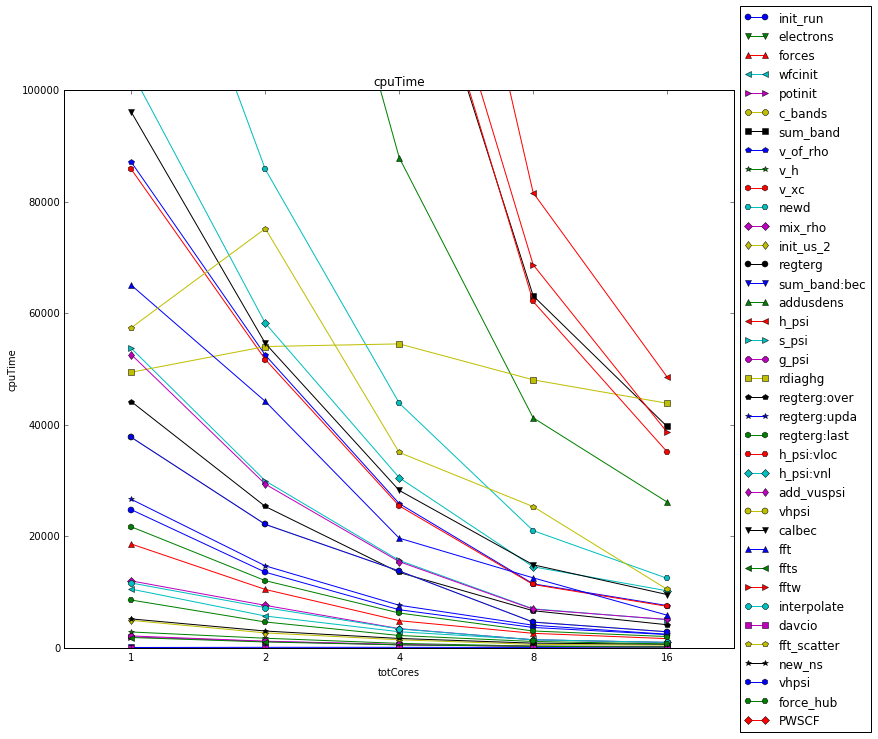

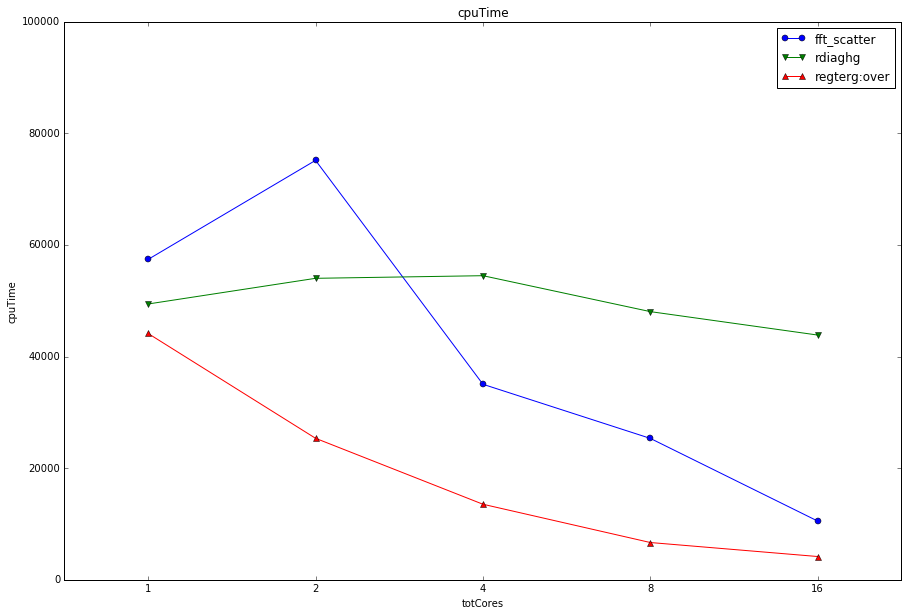

In [63]:
"""
Organized collection of espresso runs
"""
class Experiment :
    def __init__(self) :
        self.runs = []
    def addRun(self,espressoRun) :
        self.runs.append(espressoRun)
    def plotFunction(self,functions=['PWSCF'],metric='cpuTime',orderBy='totCores'):
        #data = [{'index':index,'value':run.df[run.df.name == functionName][metric].values[0]} for run,index in zip(self.runs,range(len(self.runs))) ]
        data=[]
        for run,index in zip(self.runs,range(len(self.runs))) :
            toAppend =  dict(index=index)
            values = [run.df[run.df.name == functionName][metric].values[0] for functionName in functions]
            toAppend['values']=values
            data.append(toAppend)
            
        
        #order by could be or in the header or a column of the df
        if orderBy in self.runs[0].header.keys() :
            for i,pos in zip(data,range(len(data))) :
                data[pos]['orderBy']= self.runs[i['index']].header[orderBy]
                
        dataSorted = sorted(data,key=lambda x : x['orderBy'])
        
        print dataSorted
        
        left = range(1,2*len(dataSorted)+1,2)
        xticks = left
        xticklabels = [ i['orderBy'] for i in dataSorted]
        width = 1
        
        plt.xticks(xticks,xticklabels)
        plt.xlabel(orderBy)
        plt.xlim(0,xticks[-1]+1)
        plt.ylabel(metric)
        plt.title(metric)
        marker = itertools.cycle(('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd'))
        for functionName,index in zip(functions,range(len(functions))) :
            ys=[ i['values'][index] for i in dataSorted]
            plt.plot(left,ys,label=functionName, marker= marker.next())
        plt.legend()
            

xp = Experiment()
xp.addRun(experiment16)
xp.addRun(experiment8)
xp.addRun(experiment4)
xp.addRun(experiment2)
xp.addRun(experiment1)

plt.figure(figsize=(15,10))
ax = plt.subplot(111)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis


plt.ylim(0,100000)
xp.plotFunction(functions=list(experiment1.df.name.values))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.figure(figsize=(15,10))
plt.ylim(0,100000)
xp.plotFunction(functions=['fft_scatter','rdiaghg','regterg:over'])

    

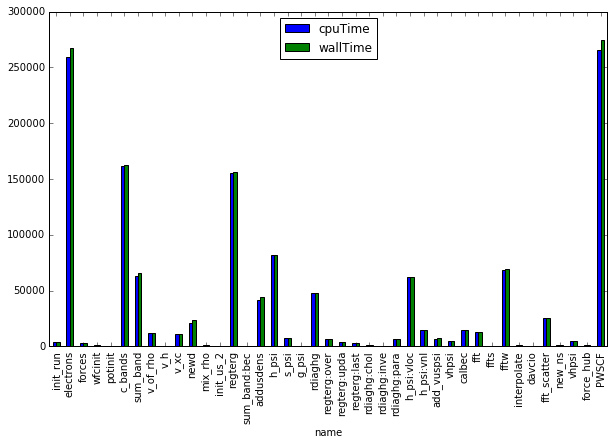

In [35]:
experiment8.getGlobalStackedPlot()




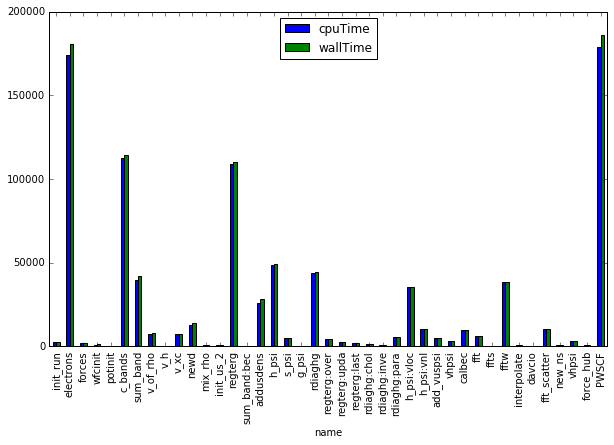

In [38]:
experiment16.getGlobalStackedPlot()

In [26]:
#all the elements in exp8 but not in exp 4
missing4 = experiment8.df.name[  experiment8.df.name.isin(experiment4.df.name) == False].index.values

exp4_yfill=list(experiment4.df.cpuTime.values)
exp2_yfill=list(experiment2.df.cpuTime.values)
exp1_yfill=list(experiment1.df.cpuTime.values)
#exp4_yfill.insert()
#experiment2.df.name[ experiment2.df.name.isin(experiment1.df.name) == False ]


for i in missing4 :
    exp4_yfill.insert(i,0)
    exp2_yfill.insert(i,0)
    exp1_yfill.insert(i,0)
    
#exp4_yfill

In [27]:
 experiment2.df.name[  experiment2.df.name.isin(experiment1.df.name) == False].index.values


array([], dtype=int64)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80]


([<matplotlib.axis.XTick at 0x7fc2041c4110>,
 <a list of 5 Text yticklabel objects>)

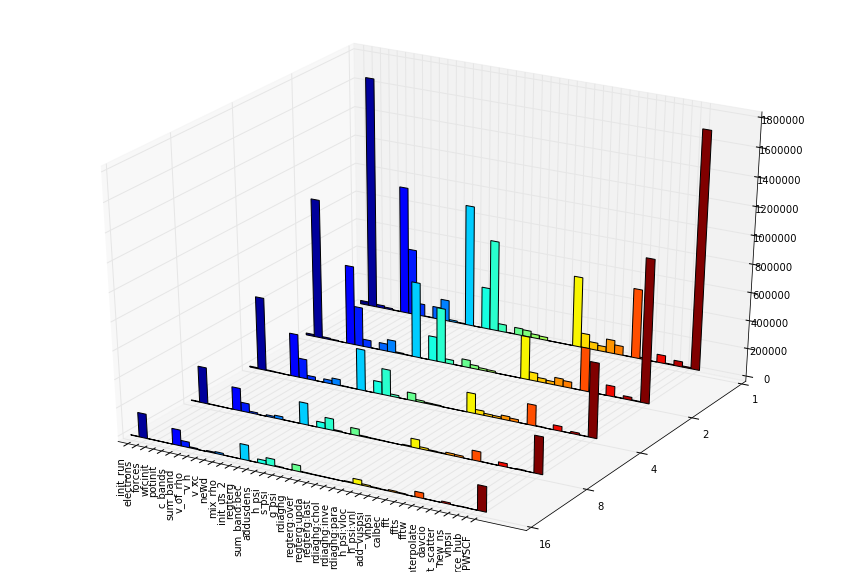

In [28]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
left = [ i for i in np.arange(2*len(experiment8.df)) if i %2 == 0]
print left
cmap = plt.cm.jet
cs=[ cmap(float(i)/max(left)) for i in left]
#ax.bar(left,experiment2.df.cpuTime,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)

ax.bar(left,exp1_yfill,zs=2,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp2_yfill,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp4_yfill,zs=1,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment8.df.cpuTime,zs=0.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment16.df.cpuTime,zs=0,zdir='y',label='cpuTime',color=cs,width=2)
#plt.bar()
plt.ylim(0,2)
plt.xticks(np.array(left) + 0.5,experiment16.df.name,rotation=90)
plt.yticks([0,0.5,1,1.5,2],reversed([1,2,4,8,16]))

In [ ]:
getStackedGlobalPlot(datas)

In [ ]:
groupped=datas.groupby('Parent')

In [ ]:
groupped

In [ ]:
groupped.groups

In [ ]:
for name,group in groupped :
    print "name: %s"%name
    print min(group.index),max(group.index)
    